# Pix2Pix GAN Implementation on Cyclone Dataset

# Objectives

- To implement a Generative Adversarial Network based approach to generate high resolution passive microwave rainfall images from satellite infrared images.

- To compare the performance of proposed model with existing models.

- To investigate and identify the challenges involved in using infrared imagery which is readily available from satellite sources, to generate passive microwave images.

# Data Preparation - Preprocessing the images

- The dataset used has paired images, so the image has to be split into the corresponding halves pertaining to each domain (Infrared and Passive Microwave Rainfall).
- The split images are to be resized to 256x256, reshaped to have depth of 3 (for RGB channels) and stored separately.
- The processed images are then stored into a `.npz` Numpy array file for later usage.

In [68]:
import cv2
import os
import numpy as np

from numpy import savez_compressed
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img

# For older version of Keras/Tensorflow
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img

# Define the path to directory
directory = 'C:\\Users\\kbdha\\Downloads\\mini-project\\TCIRRP\\train0.01k'

# Get a list of all the file paths that are in the directory
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images
images = np.array([cv2.imread(img_path) for img_path in image_paths])

pmw = []
ir = []

# Process each image
for i in range(len(images)):
    # Split the image into two halves
    image1 = images[i][0:201, 0:201]
    image2 = images[i][0:201, 201:402]

    # Resize the images to 256x256
    image1 = cv2.resize(image1, (256, 256))
    image2 = cv2.resize(image2, (256, 256))

    # Reshape the images
    image1 = image1.reshape(256, 256, 3)
    image2 = image2.reshape(256, 256, 3)

    # Append the images to the respective lists
    pmw.append(image1)
    ir.append(image2)

# Convert the lists to numpy arrays
pmw = np.array(pmw)
ir = np.array(ir)

# Print the shapes of the arrays
print("Loaded", pmw.shape, ir.shape)

# Save the arrays as a compressed numpy array
filename = 'pmwtoir1_256.npz'
savez_compressed(filename, ir, pmw)

print('Saved dataset: ', filename)

Loaded (10, 256, 256, 3) (10, 256, 256, 3)
Saved dataset:  pmwtoir1_256.npz


# Defining the architecture 

In [69]:
# Importing packages
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import plot_model
from matplotlib import pyplot

# Defining the Discriminator Model

The discriminator takes a source image and a target image as input, concatenates them, and passes them through several convolutional layers. Each convolutional layer is followed by a batch normalization (except the first one) and a LeakyReLU activation. The output of the model is a patch output, which is a high-level feature representation of the input images. The model is compiled with the Adam optimizer and binary cross entropy loss.

In [70]:
# Define the discriminator model
def define_discriminator(image_shape):
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Define input for source image
    in_src_image = Input(shape=image_shape)

    # Define input for target image
    in_target_image = Input(shape=image_shape)

    # Concatenate source and target images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # Convolutional layer with 64 filters, followed by LeakyReLU activation
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolutional layer with 128 filters, followed by BatchNormalization and LeakyReLU activation
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolutional layer with 256 filters, followed by BatchNormalization and LeakyReLU activation
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolutional layer with 512 filters, followed by BatchNormalization and LeakyReLU activation
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    # Define the model
    model = Model([in_src_image, in_target_image], patch_out)

    # Compile the model with Adam optimizer and binary cross entropy loss
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    # model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

# Defining the Encoder Block for Generator Model

The encoder block consists of a convolutional layer for downsampling the input, followed by an optional batch normalization layer, and a LeakyReLU activation function. The purpose of the encoder block is to extract and downsample features from the input image.

In [71]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Add a downsampling layer: a convolutional layer with stride 2
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

    # Conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)

    # Add LeakyReLU activation with slope 0.2
    g = LeakyReLU(alpha=0.2)(g)

    return g

# Defining the Decoder Block for Generator model

The decoder block consists of a transposed convolutional layer for upsampling the input, a batch normalization layer, an optional dropout layer, and a ReLU activation function. The decoder block also includes a skip connection, which merges the output of the corresponding encoder block with the output of the decoder block. This helps the generator model to better capture the details of the input image.

In [72]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Add an upsampling layer: a transposed convolutional layer with stride 2
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

    # Add batch normalization
    g = BatchNormalization()(g, training=True)

    # Conditionally add dropout with rate 0.5
    if dropout:
        g = Dropout(0.5)(g, training=True)

    # Merge this layer with the skip-connected layer
    g = Concatenate()([g, skip_in])

    # Add ReLU activation
    g = Activation('relu')(g)

    return g

# Defining the Generator Model

The generator model is an encoder-decoder model, where the encoder extracts features from the input image and the decoder upsamples these features to generate a new image. The generator also includes skip connections between the encoder and decoder blocks, which help to preserve the details of the input image in the generated image. The output of the generator is an image with the same dimensions as the input image.

In [73]:
# Define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Define input for the image
    in_image = Input(shape=image_shape)

    # Define encoder blocks
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    # Bottleneck layer with no batch normalization and ReLU activation
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    # Define decoder blocks
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # Output layer with tanh activation
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    # Define the model
    model = Model(in_image, out_image)

    return model

# Defining the Composite Model

The combined model is used for updating the generator. The discriminator's weights are frozen during the generator update. The model takes a source image as input and outputs a generated image and a classification output. The model is compiled with the Adam optimizer, binary cross entropy loss for the discriminator, and mean absolute error loss for the generator. The loss weights indicate that the generator's loss has 100 times more impact on the total loss than the discriminator's loss.

In [74]:
def define_gan(g_model, d_model, image_shape):
    # Make weights in the discriminator not trainable, except for BatchNormalization layers
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    # Define the source image
    in_src = Input(shape=image_shape)

    # Connect the source image to the generator input
    gen_out = g_model(in_src)

    # Connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])

    # Define the model with source image as input and generated image and classification output
    model = Model(in_src, [dis_out, gen_out])

    # Compile the model with Adam optimizer, binary cross entropy and mean absolute error loss
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1.0,100.0])

    return model

# Defining helper functions for easy image access

These functions are used to load and prepare the training images for a Pix2Pix GAN.

- `load_real_samples` function loads the training images from a file and scales the pixel values from the range [0,255] to the range [-1,1].
- `generate_real_samples` function selects a batch of random samples from the training images and generates corresponding 'real' class labels.
- `generate_fake_samples` function uses the generator model to generate a batch of fake images and creates corresponding 'fake' class labels.

In [75]:
# Load and prepare training images
def load_real_samples(filename):
    # Load compressed arrays
    data = load(filename)
    
    # Unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    
    # Scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    return [X1, X2]
 
# Select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # Unpack dataset
    trainA, trainB = dataset
    
    # Choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    
    # Retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # Generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y
 
# Generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # Generate fake instance
    X = g_model.predict(samples)
    
    # Create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

# Summarizing the performance

- `summarize_performance` function generates a batch of real and fake samples, plots them, and saves the plot and the generator model to files. The plots provide a visual progress of the training process.
- `save_models` function saves the generator model to a file. This allows the training process to be resumed at a later time, or the trained model to be used to generate new images.

In [76]:
# Generate samples, save them as a plot, and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # Select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    
    # Generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    
    # Scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    # Plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    
    # Plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    
    # Plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    
    # Save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # Save the generator model
    filename2 = 'model_%06d.keras' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# Save the generator model
def save_models(step, g_model_AtoB):
    # Save the first generator model
    filename1 = 'g_model_AtoB_%06d.keras' % (step+1)
    g_model_AtoB.save(filename1)
    
    print('>Saved:%s' % (filename1))

# Training the Model

This code block trains the Pix2Pix models. It first loads the image data and defines the models. Then it trains the models for a specified number of epochs, updating the discriminator and generator models in each step. The trained models are saved only for the first and last step. The summary of the GAN model is printed before the training starts.

Loaded (10, 256, 256, 3) (10, 256, 256, 3)


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_22 (Functional)          (None, 256, 256, 3)  54429315    ['input_32[0][0]']               
                                                                                                  
 model_21 (Functional)          (None, 16, 16, 1)    6968257     ['input_32[0][0]',               
                                                                  'model_22[0][0]']               
                                                                                           

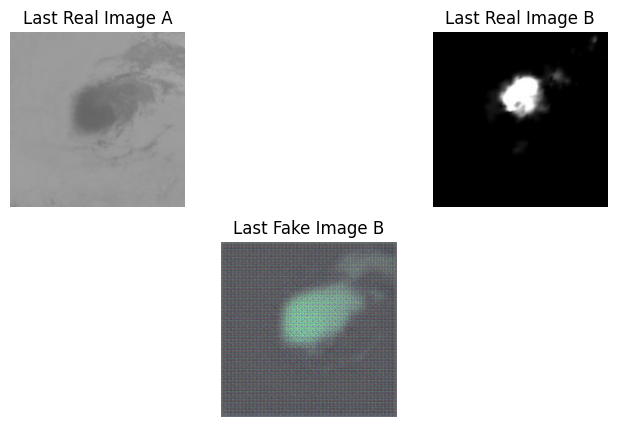

In [77]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1):
    # Determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    # Unpack dataset
    trainA, trainB = dataset
    
    # Calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    
    # Calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    # Prepare lists for storing samples for visualization
    all_realA, all_realB, all_fakeA, all_fakeB = [], [], [], []
    
    # Manually enumerate epochs
    for i in range(n_steps):
        # Select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        
        # Generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        
        # Store samples for visualization
        all_realA.append(X_realA)
        all_realB.append(X_realB)
        all_fakeB.append(X_fakeB)
        
        # Update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        
        # Update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        
        # Update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # Summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        # Summarize model performance and save models only for the first and last step
        if i == 0 or i == n_steps - 1:
            summarize_performance(i, g_model, dataset)
            save_models(i, g_model)
    
    # Convert the lists to numpy arrays for visualization
    all_realA = np.concatenate(all_realA)
    all_realB = np.concatenate(all_realB)
    all_fakeB = np.concatenate(all_fakeB)

    # Create a new figure
    plt.figure(figsize=(10,5))

    # Create a gridspec
    gs = gridspec.GridSpec(2, 2)

    # Plot the last real image from A and B
    plt.subplot(gs[0, 0]) # top left
    plt.title('Last Real Image A')
    plt.imshow((all_realA[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    plt.subplot(gs[0, 1]) # top right
    plt.title('Last Real Image B')
    plt.imshow((all_realB[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    # Plot the last fake image from B
    plt.subplot(gs[1, :]) # bottom, span both columns
    plt.title('Last Fake Image B')
    plt.imshow((all_fakeB[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    # Show the figure with the images
    plt.show()

# Load image data
dataset = load_real_samples('pmwtoir1_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# Define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# Define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# Define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

# Print the summary of the GAN model
gan_model.summary()

plot_model(gan_model, to_file='gan-model-AtoB-plot.png', show_shapes=True, show_layer_names=True)

# Train model
train(d_model, g_model, gan_model, dataset)

# Testing the Model

This code block tests the Pix2Pix models. It first loads the image data and the generator model. Then it generates a batch of real and fake samples and plots them. Then the performance of the model is summarized.


In [78]:
print(pmw.shape)

(10, 256, 256, 3)


# Preparing the Dataset for Testing

Shape of pmw array:  (10, 256, 256, 3)


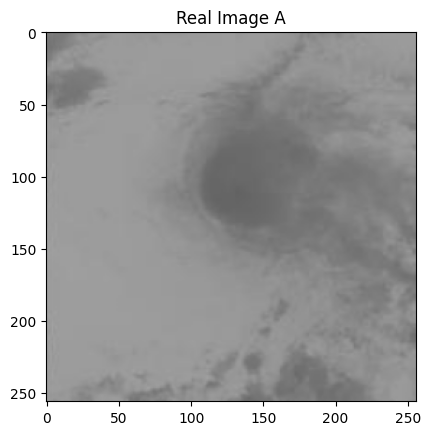

In [79]:
# Import necessary packages
import cv2
import os
import numpy as np
from numpy import asarray
from numpy import vstack
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from numpy import savez_compressed
import matplotlib.pyplot as plt

# Dataset directory path
directory = r'C:\Users\kbdha\Downloads\mini-project\TCIRRP\test0.01k'

# Get a list of all the file paths
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images in grayscale
images = np.array([cv2.imread(img_path) for img_path in image_paths])

# Initialize empty list
pmw = []
ir = []

# Iterate over all images
for i in range(len(images)):
    # Split the image into two halves
    image1 = images[i][0:201, 0:201]
    image2 = images[i][0:201,201:402]
    
    # Resize both halves of the image to 256x256
    image1 = cv2.resize(image1,(256,256))
    image2 = cv2.resize(image2,(256,256))
    
    # Reshape both halves of the image to have a depth of 3 (for RGB channels)
    image1 = image1.reshape(256,256,3)
    image2 = image2.reshape(256,256,3)
    
    # Append the processed halves of the image to their respective lists
    pmw.append(image1)
    ir.append(image2)

# Convert the lists to numpy arrays
pmw = np.array(pmw)
ir = np.array(ir)

# Print the shape of the 'pmw' array
print('Shape of pmw array: ', pmw.shape)

# Display the first image in the 'ir' array
plt.title('Real Image A')
plt.imshow(ir[0])

# Load Model

The model is loaded from the file and used to generate a batch of images. The a few generated images are then plotted and performance is calculated.

In [80]:
from keras.models import load_model

# Load the model that transforms images from domain A to domain B
model_AtoB = load_model('C:\\Users\\kbdha\\Downloads\\mini-project\\Pix2Pix\\model_000010.keras', compile=False)
ir=(ir-127.5)/127.5
pmw=(pmw-127.5)/127.5

# Predicting Images with the Model

 `model_AtoB` predicts the transformation of images from domain A to domain B.
 
 The predictions are then reshaped to their original shape and scaled to the range [0, 1]. The first image in the 'predict' and 'pmw' arrays, as well as the shape of these arrays, are then printed.

In [81]:
# Initialize an empty list to store predictions
predicted = []

# Iterate over all images in 'pmw'
for i in range(len(pmw)):
    # Reshape the images to match the input shape of the model
    k = ir[0].reshape(1, 256, 256, 3)
    l = pmw[0].reshape(1, 256, 256, 3)
    
    # Use the model to perform the transformation
    pred = model_AtoB.predict(k)
    
    # Append the prediction to the list
    predicted.append(pred)

# Convert the list of predictions to a numpy array
predicted = np.array(predicted)

# Print the number of predictions and the shape of the 'predicted' array
print(len(predicted), predicted.shape)

# Initialize an empty list to store reshaped predictions
predict = []

# Iterate over all predictions
for i in range(len(predicted)):
    # Reshape the prediction to its original shape
    predict.append(predicted[i].reshape(256, 256, 3))

# Convert the list of reshaped predictions to a numpy array
predict = np.array(predict)

# Scale the 'pmw' and 'predict' arrays to the range [0, 1]
pmw = (pmw + 1) / 2
predict = (predict + 1) / 2

# Print the first image in the 'predict' and 'pmw' arrays
print(predict[0], pmw[0])

# Print the shape of the 'predict' and 'pmw' arrays
print(predict.shape, pmw.shape)

1/1 [==============================] - 0s 244ms/step
10 (10, 1, 256, 256, 3)
[[[0.48029163 0.5143601  0.4805918 ]
  [0.41937506 0.4965921  0.47487643]
  [0.4537299  0.518199   0.43816346]
  ...
  [0.4089305  0.45981705 0.49020416]
  [0.46388817 0.50426567 0.44696796]
  [0.5035232  0.4754877  0.49177414]]

 [[0.4403529  0.44119054 0.38225314]
  [0.42598343 0.33035952 0.4316699 ]
  [0.3876298  0.40766698 0.39426798]
  ...
  [0.36666554 0.2762134  0.38553488]
  [0.37348932 0.33936632 0.4588352 ]
  [0.41274583 0.4299796  0.5003476 ]]

 [[0.4837169  0.53452843 0.47669622]
  [0.38864115 0.36753988 0.39885557]
  [0.4782741  0.5807885  0.40797   ]
  ...
  [0.37375626 0.34057504 0.40924248]
  [0.43005016 0.5176422  0.42678154]
  [0.46986738 0.4678347  0.5346573 ]]

 ...

 [[0.4733598  0.458053   0.37538838]
  [0.45863566 0.28690577 0.39525467]
  [0.29253793 0.33239675 0.46959296]
  ...
  [0.46026582 0.27202868 0.4833733 ]
  [0.32218552 0.3282929  0.41336852]
  [0.440145   0.4016091  0.52271414]

# Plotting Images

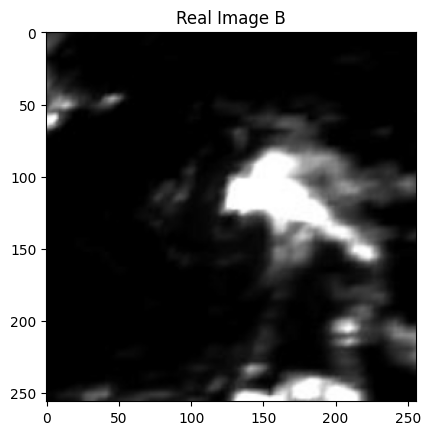

In [82]:
plt.title('Real Image B')
plt.imshow(pmw[0])

(10, 256, 256, 3) (10, 256, 256, 3)
[[[0.1372549  0.1372549  0.1372549 ]
  [0.15686275 0.15686275 0.15686275]
  [0.17647059 0.17647059 0.17647059]
  ...
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.00784314 0.00784314 0.00784314]]

 [[0.16470588 0.16470588 0.16470588]
  [0.18039216 0.18039216 0.18039216]
  [0.19607843 0.19607843 0.19607843]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]]

 [[0.19607843 0.19607843 0.19607843]
  [0.21176471 0.21176471 0.21176471]
  [0.22352941 0.22352941 0.22352941]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]]

 ...

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01568627 0.01568627 0.01568627]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.01568627 0.01568627 0.01568627]
 

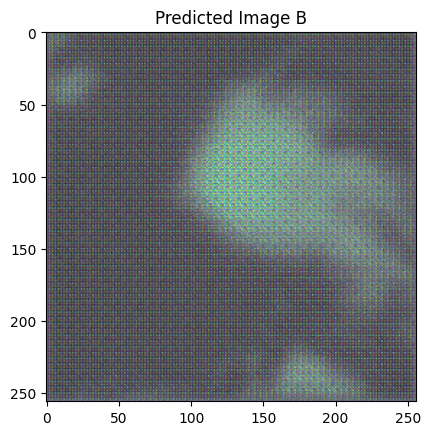

In [83]:
import matplotlib.pyplot as plt
print(pmw.shape,predict.shape)
print(pmw[0],predict[0])
plt.title('Predicted Image B')
plt.imshow(predict[0])

# Calculating Performance Metrics

Key metrics used to ensure that the generated images are similar to the ground truth images are:

- **RMSE (Root Mean Squared Error):**
  - Measures the average magnitude of pixel-wise differences between the generated and target images.
  - Lower RMSE values indicate better pixel-level similarity.
  - Sensitive to outliers and can be influenced by extreme values.

- **PSNR (Peak Signal-to-Noise Ratio):**
  - Quantifies the quality of the generated image by comparing it to the target image.
  - Higher PSNR values indicate better image quality.
  - It is a logarithmic scale, and a higher PSNR is associated with lower perceptual differences.

- **CC (Pearson Correlation Coefficient):**
  - Assesses the linear relationship between pixel intensities of the generated and target images.
  - A value close to 1 indicates a strong positive correlation, implying high similarity.
  - Not sensitive to intensity shifts but assumes a linear relationship.

- **SSIM (Structural Similarity Index):**
  - Evaluates the structural information and textures in the images.
  - Takes into account luminance, contrast, and structure.
  - SSIM values range from -1 to 1, where 1 indicates perfect similarity.
  - Multiscale and considers local features, making it suitable for assessing perceptual quality.


In [84]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from IPython.display import display, HTML
import numpy as np
import pandas as pd

def calculate_rmse(target, prediction):
    return np.sqrt(((prediction - target) ** 2).mean())

def calculate_psnr(target, prediction):
    return psnr(target, prediction, data_range=prediction.max() - prediction.min())

def calculate_cc(target, prediction):
    return pearsonr(target.flatten(), prediction.flatten())[0]

def calculate_ssim(target, prediction):
    # Use a smaller window size for SSIM calculation
    return ssim(target, prediction, win_size=3, multichannel=True, data_range=prediction.max() - prediction.min())

target = np.array(pmw)
prediction = predict
rmse=0
psnrv=0
cc=0
ssimv=0
n=len(target)
print(n,prediction.shape)
for i in range(n):
    rmse+= calculate_rmse(target[i], prediction[i])
    psnrv+= calculate_psnr(target[i], prediction[i])
    cc+= calculate_cc(target[i], prediction[i])
    ssimv+= calculate_ssim(target[i], prediction[i])
rmse=rmse/n
psnrv=psnrv/n
cc=cc/n
ssimv=ssimv/n
print(calculate_rmse(target[0],prediction[0]))
# Create a DataFrame to display the results
df = pd.DataFrame({
    'Metric': ['RMSE', 'PSNR', 'CC', 'SSIM '],
    'Value': [np.sqrt(rmse*255), psnrv, cc, ssimv]
})

# Convert the DataFrame to HTML
df_html = df.to_html()

# Display the HTML
display(HTML(df_html))

10 (10, 256, 256, 3)
0.35055252486401456


,Metric,Value
0,RMSE,9.553345
1,PSNR,7.675396
2,CC,0.341752
3,SSIM,0.019685
